## Praca domowa nr 6
W tej pracy domowej zajmiemy się analizą zbioru zawierającego zdjęcia pod nazwą Olivetti Faces. Zobaczymy jak algorytmy PCA działają na tego typu danych oraz jak transformacja odwrotna oraz inne modyfikacje wpływają na błąd względem oryginału przy rekonstrukcji obrazu.

In [1]:
#import pakietów
from sklearn.datasets import fetch_olivetti_faces
from IPython.display import display, Image
from matplotlib import pyplot as plt
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import preprocess_input
import numpy as np
import tensorflow as tf
import PIL
from PIL import Image

from sklearn.decomposition import PCA

In [2]:
Olivetti_faces = fetch_olivetti_faces()

In [3]:
Olivetti_faces

{'data': array([[0.30991736, 0.3677686 , 0.41735536, ..., 0.15289256, 0.16115703,
         0.1570248 ],
        [0.45454547, 0.47107437, 0.5123967 , ..., 0.15289256, 0.15289256,
         0.15289256],
        [0.3181818 , 0.40082645, 0.49173555, ..., 0.14049587, 0.14876033,
         0.15289256],
        ...,
        [0.5       , 0.53305787, 0.607438  , ..., 0.17768595, 0.14876033,
         0.19008264],
        [0.21487603, 0.21900827, 0.21900827, ..., 0.57438016, 0.59090906,
         0.60330576],
        [0.5165289 , 0.46280992, 0.28099173, ..., 0.35950413, 0.3553719 ,
         0.38429752]], dtype=float32),
 'images': array([[[0.30991736, 0.3677686 , 0.41735536, ..., 0.37190083,
          0.3305785 , 0.30578512],
         [0.3429752 , 0.40495867, 0.43801653, ..., 0.37190083,
          0.338843  , 0.3140496 ],
         [0.3429752 , 0.41735536, 0.45041323, ..., 0.38016528,
          0.338843  , 0.29752067],
         ...,
         [0.21487603, 0.20661157, 0.2231405 , ..., 0.15289256,
     

Dokonując pomniejszego streszczenia zbioru, zawiera 400 zdjęć osobników ludzkich o różnych ekspresjach twarzy oraz różnych ich charakterystykach. Wszystkie zostały wykonane na przeciw czarnej, homogenicznej teksturze, z partycypantem spoglądającym w frontalnej(lub prawie frontalnej) pozycji na kamere. 

In [4]:
Olivetti_faces.images.shape

(400, 64, 64)

In [5]:
Olivetti_faces.data.shape

(400, 4096)

In [6]:
Olivetti_faces.target.shape

(400,)

Przed przejściem dalej do analizy zauważmy, iż w zbiorze danych Olivetti_faces "data" odpowiada wartościami "images"; jest to po prostu ciąg danych wyrażonych w nie uporządkowanych tablicach. Poniżej dokonuje sprawdzenia ów faktu.

In [7]:
aa = Olivetti_faces.data.reshape(400,64,64)

In [8]:
(aa == (Olivetti_faces.images)).all()

True

### Zadanie 0
Zobaczmy jak prezentują się obrazy.

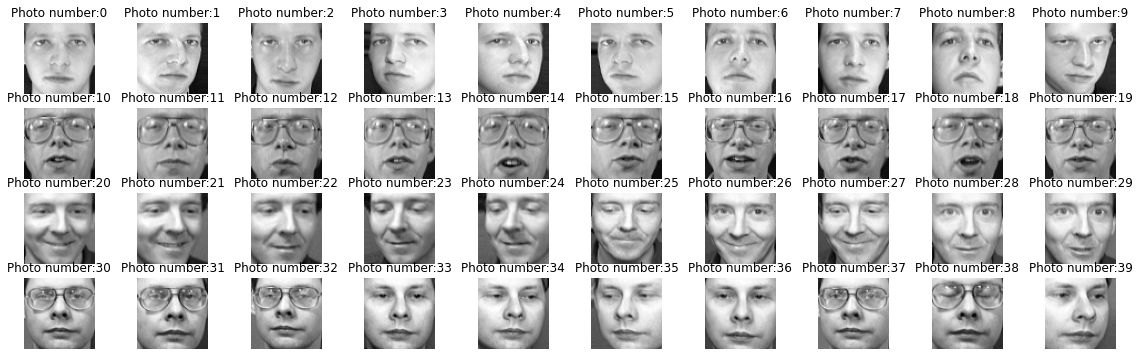

In [9]:
images = Olivetti_faces.images
data = Olivetti_faces.data
indexes = range(40)

fig, axs = plt.subplots(4, 10, figsize=(20, 6))
for j in range(40):
    axs[j//10,j%10].imshow(images[j],cmap="gray")
    axs[j//10,j%10].set_title(f"Photo number:{indexes[j]}")
    axs[j//10,j%10].grid(False)
    axs[j//10,j%10].axis('off')

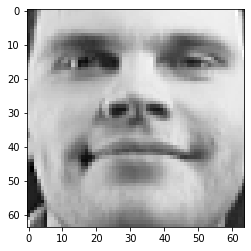

In [10]:
#funkcja do wypisywania jednego zdjecia
def show_face(image):
    plt.imshow(np.reshape(image, (64, 64)), cmap="gray")
show_face(images[350])

### Zadanie 1
Ok, dokonajmy kompresji naszych danych z pomocą algorytmu PCA. Postaramy dobrać się również optymalną ilość składowych by zmaksymalizować stosunek wyjaśnionej wariancji do ilości komponentów.

In [11]:
def make_compressed_set(image_array,model):
    array = []
    for image in image_array:
        array.append(model.fit_transform(image))
    return array

In [12]:
pca_photoes = PCA()
pca_photoes.fit(data)

PCA()

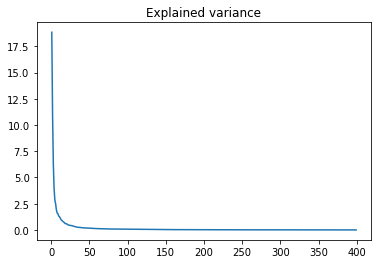

In [13]:
plt.plot(range(1, 400), pca_photoes.explained_variance_[0:399])
plt.title("Explained variance")
plt.show()

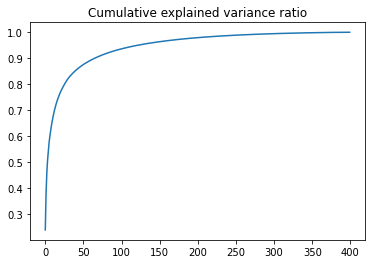

In [14]:
plt.plot(range(400), np.cumsum(pca_photoes.explained_variance_ratio_))
plt.title("Cumulative explained variance ratio")
plt.show()

Jak widzimy ilość wyjaśnianej wariancji rośnie dość szybko wraz z progresją ilości elementów, więc ile komponentów należy dobrać? Możemy posłużyć się arbitralnym wyborem, niemniej jednak różne źródła (np. https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/) sugerują dobór tylu komponentów, by ilość wyjaśnialnej wariancji była w granicach 95-99%.  
Zatem sprawdźmy ilu komponentom by to odpowiadało.

In [15]:
#Użycie liczby z przedziału (0,1) zwraca nam model z tyloma elementami, które zasytasfakcjonują prób wyjaśnionej wariancji
#Sprawdźmy to
pca_95 = PCA(n_components = 0.95)
pca_95.fit(data)
n_components = len(pca_95.explained_variance_ratio_)
np.cumsum(pca_95.explained_variance_ratio_)[-1]
print(f"Ilość komponentów wynosi: {n_components}")
print(np.cumsum(pca_95.explained_variance_ratio_)[-1])

Ilość komponentów wynosi: 123
0.95038956


Zatem dokonajmy kompresji, z użyciem pca_95.

In [83]:
data_transformed = pca_95.fit_transform(data)

In [17]:
data_transformed.shape

(400, 123)

Z linku, w który zostaliśmy zaopatrzeni w poleceniach, jest to stosunek rozmiaru przed skompresowaniem do rozmiaru po skompresowaniu. Ponieważ dane przed kompresją i po niej mają ten sam typ, w takim razie *CR* wynosi: 

In [18]:
print(f"CR = {data.shape[1]/data_transformed.shape[1]}")

CR = 33.300813008130085


### 2. Transformacja odwrotna, dekompresja

In [19]:
from sklearn.metrics import mean_squared_error
data_decompressed = pca_95.inverse_transform(data_transformed)
data_decompressed.shape

(400, 4096)

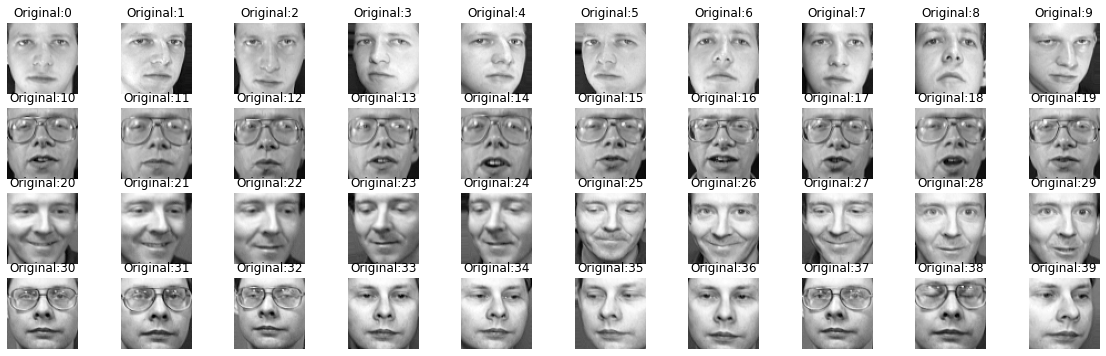

In [105]:
fig, axs = plt.subplots(4, 10, figsize=(20, 6))
for j in range(40):
        axs[j//10,j%10].imshow(images[j],cmap="gray")
        axs[j//10,j%10].set_title(f"Original:{j}")
        axs[j//10,j%10].grid(False)
        axs[j//10,j%10].axis('off')

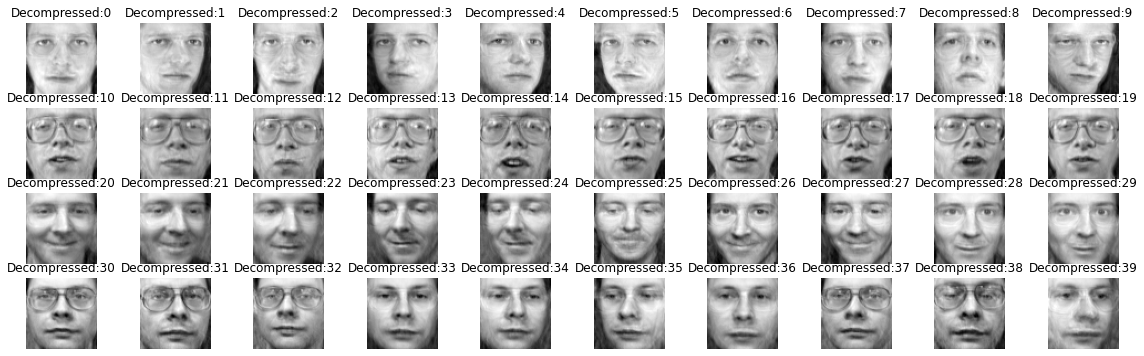

In [106]:
fig, axs = plt.subplots(4, 10, figsize=(20, 6))
for j in range(40):
    axs[j//10,j%10].imshow(np.reshape(data_decompressed[j], (64, 64)), cmap="gray")
    axs[j//10,j%10].set_title(f"Decompressed:{j}")
    axs[j//10,j%10].grid(False)
    axs[j//10,j%10].axis('off')

Ponieważ informacja o RMSE nie zmieściła by się na plocie, w takim razie umieszczam ją poniżej, odpowiednio dla każdej pary obrazków.

In [107]:
for j in range(40):
        d = mean_squared_error(data[j], data_decompressed[j], squared=False)
        print(f"RMSE for pair {j} equals {d}")

RMSE for pair 0 equals 0.02993145026266575
RMSE for pair 1 equals 0.032406240701675415
RMSE for pair 2 equals 0.03161066770553589
RMSE for pair 3 equals 0.03181198984384537
RMSE for pair 4 equals 0.030762838199734688
RMSE for pair 5 equals 0.029906386509537697
RMSE for pair 6 equals 0.03422338888049126
RMSE for pair 7 equals 0.031081918627023697
RMSE for pair 8 equals 0.032091960310935974
RMSE for pair 9 equals 0.034497011452913284
RMSE for pair 10 equals 0.034855809062719345
RMSE for pair 11 equals 0.03631854057312012
RMSE for pair 12 equals 0.03195063769817352
RMSE for pair 13 equals 0.03169982135295868
RMSE for pair 14 equals 0.031334880739450455
RMSE for pair 15 equals 0.026625802740454674
RMSE for pair 16 equals 0.033856071531772614
RMSE for pair 17 equals 0.03088390827178955
RMSE for pair 18 equals 0.02780005894601345
RMSE for pair 19 equals 0.033010419458150864
RMSE for pair 20 equals 0.03010399453341961
RMSE for pair 21 equals 0.027858451008796692
RMSE for pair 22 equals 0.0271

In [22]:
#Średnia dla całego zbioru
mean_squared_error(data, data_decompressed, squared=False)

0.02997054

In [23]:
#Dla każdego obrau
rmse_array = []
for i in range(data.shape[0]):
    rmse_array.append(mean_squared_error(data[i], data_decompressed[i], squared=False))

In [24]:
#min oraz max
print(min(rmse_array))
print(max(rmse_array))

0.022124436
0.038971264


### 3. Modyfikacja obrazów
W tym punkcie na poczet następnego dokonamy kilku modyfikacji naszych obrazów, by następnie na nich operować w dalszym punkcie.  
Wykorzystajmy kilka modyfikacji w tym celu pakiet PIL, oferujący różnorodne oraz zgrabne narzędzia do modyfikacji obrazów. Rónież by mieć pewne odniesienie, będziemy modyfikować jedynie piewszy obraz.

#### Rotacje, 45, 90 i 120 stopni

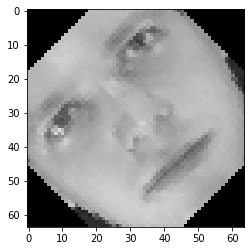

In [25]:
#Obrót 45 stopni
image_rot45 = Image.fromarray(images[0]*255).rotate(45)
plt.imshow(image_rot45)

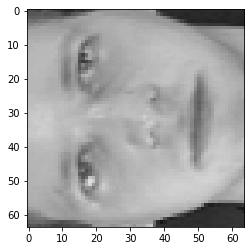

In [26]:
#Obrót 90 stopni
image_rot90 = Image.fromarray(images[0]*255).rotate(90)
plt.imshow(image_rot90)

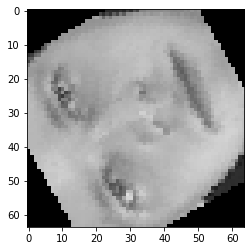

In [27]:
#Obrót 120 stopni
image_rot120 = Image.fromarray(images[0]*255).rotate(120)
plt.imshow(image_rot120)

#### Horizontal flip oraz vertical flip

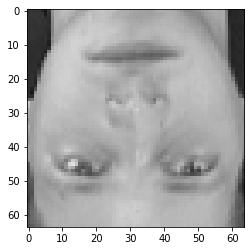

In [28]:
image_hflip = Image.fromarray(images[0]*255).transpose(PIL.Image.FLIP_TOP_BOTTOM)
plt.imshow(image_hflip)

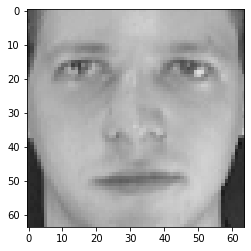

In [29]:
image_vflip = Image.fromarray(images[0]*255).transpose(PIL.Image.FLIP_LEFT_RIGHT)
plt.imshow(image_vflip)

#### Przyciemnianie oraz rozjaśnianie

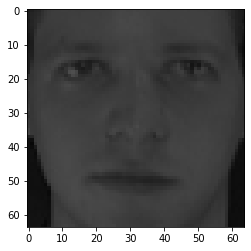

In [30]:
image_darken = Image.fromarray(images[0]*255).point(lambda x: x * 0.35)
plt.imshow(image_darken)

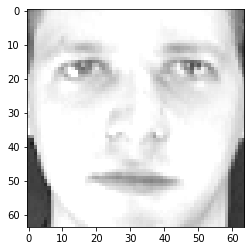

In [31]:
image_lighten = Image.fromarray(images[0]*255).point(lambda x: x * 1.4)                                                
plt.imshow(image_lighten)

#### Insert random dark/white pixels

In [32]:
import random
def insert_pixels(image,n,dark = True):
    a = np.reshape(image, (4096))
    pixels = random.sample(range(4096), n)
    pixels = np.array(pixels)
    if dark == True:
        a[pixels] = 0
    else:
        a[pixels] = 255
    return np.reshape(a,(64,64))

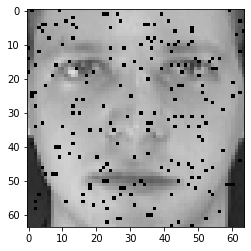

In [33]:
image_200pixels = insert_pixels(images[0],200,dark=True)
image_200pixels = Image.fromarray(image_200pixels*255)                                             
plt.imshow(image_200pixels)

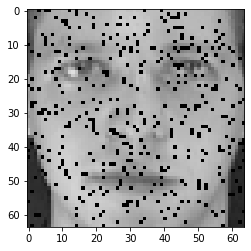

In [34]:
image_400pixels = insert_pixels(images[0],400,dark=True)
image_400pixels = Image.fromarray(image_400pixels*255)                                             
plt.imshow(image_400pixels)

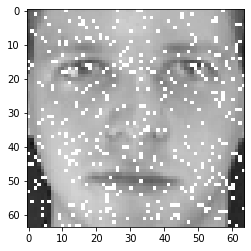

In [35]:
image_400pixels_white = insert_pixels(images[0],400,dark=False)
image_400pixels_white = Image.fromarray(image_400pixels_white*255)                                             
plt.imshow(image_400pixels_white)

### 4. Transformacja i rekonstrukcja obrazów z punktu 3
Przygotowawszy nasze dane, dokonajmy teraz próby ich dekonstrukcji oraz rekonstrukcji oraz prześledźmy wyniki przy względzie na błąd średniokwadratowy.

In [84]:
pca_95.fit(data)

PCA(n_components=0.95)

In [85]:
def show_both(image,model):

    reconstructed = pca_95.inverse_transform(pca_95.transform(np.reshape(image,(1, -1))))
    
    fig,axs = plt.subplots(1, 2, figsize=(10, 6))
    axs[0].imshow(image,cmap="gray")
    axs[0].set_title(f"Original photo")
    axs[0].grid(False)
    axs[0].axis('off')
    
    axs[1].imshow(np.reshape(reconstructed,(64,64)),cmap="gray")
    axs[1].set_title(f"Reconstructed photo")
    axs[1].grid(False)
    axs[1].axis('off')
    
    a = mean_squared_error(np.reshape(image,(1,4096)), reconstructed, squared=False)
    print(f"Mean Squared Error = {a}")

Mean Squared Error = 24.968185424804688


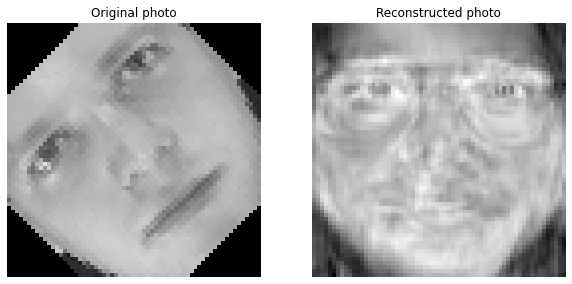

In [86]:
show_both(image_rot45,pca_95)

Mean Squared Error = 17.713560104370117


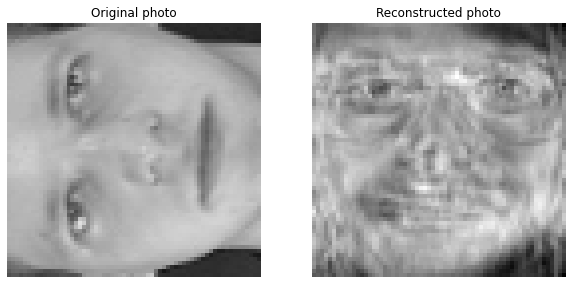

In [87]:
show_both(image_rot90,pca_95)

Mean Squared Error = 22.659278869628906


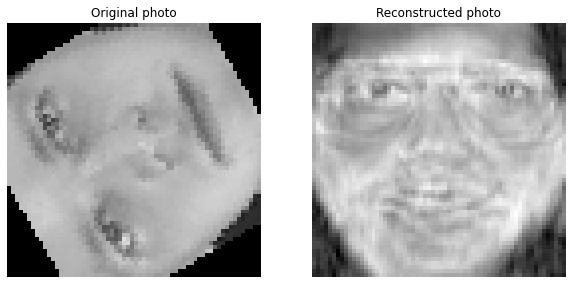

In [88]:
show_both(image_rot120,pca_95)

Mean Squared Error = 17.267778396606445


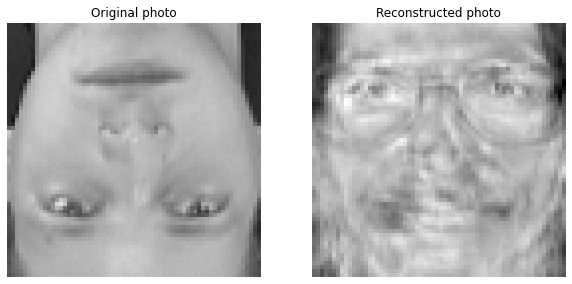

In [89]:
show_both(image_hflip,pca_95)

Mean Squared Error = 10.821048736572266


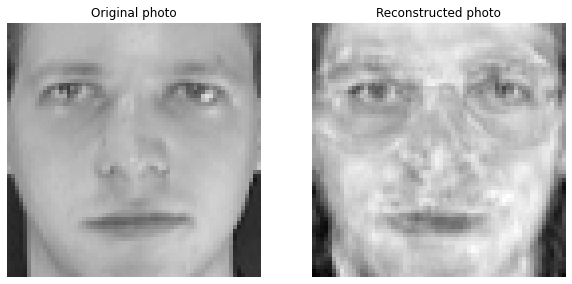

In [90]:
show_both(image_vflip,pca_95)

Mean Squared Error = 3.2445597648620605


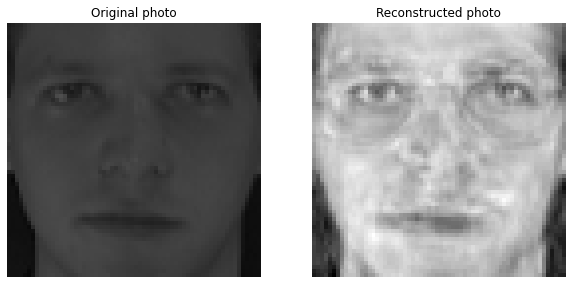

In [91]:
show_both(image_darken,pca_95)

Mean Squared Error = 13.050186157226562


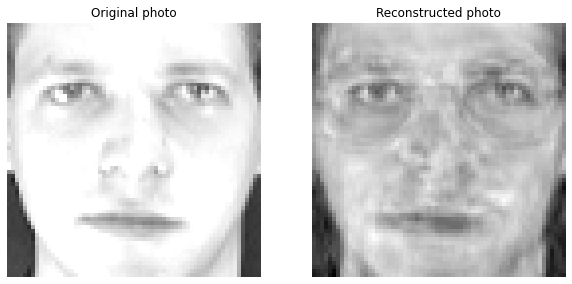

In [92]:
show_both(image_lighten,pca_95)

Mean Squared Error = 19.29088592529297


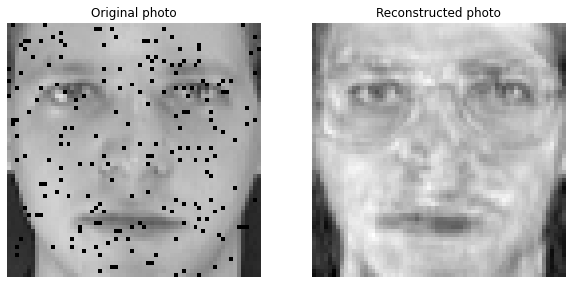

In [93]:
show_both(image_200pixels,pca_95)

Mean Squared Error = 30.69329071044922


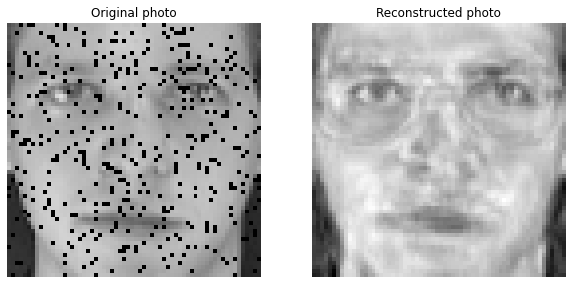

In [94]:
show_both(image_400pixels,pca_95)

Mean Squared Error = 11154.8701171875


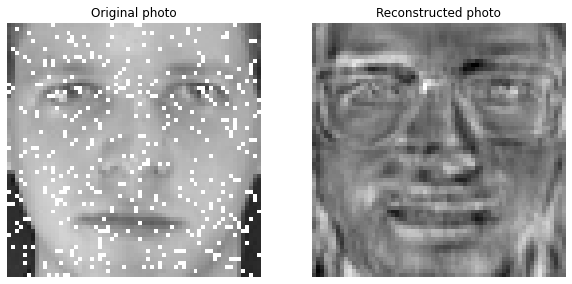

In [95]:
show_both(image_400pixels_white,pca_95)

Jak przekonaliśmy się na powyżej wypisanych grafikach, niektóre modyfikacje wpływają w sposób bardziej znaczący na ostateczną rekonstrukcję. Przypominam, iż dla użytej grafiki, błąd średniokwadratowy dla nie zmodyfikowanego zdjęcia był na poziomie 0.3.  
Najmniejszy wpływ na rekonstrukcje miały przyciemnianie, rozjaśnianie oraz dokonywanie lustrzanego odbicia względem oryginału. W tych przypadkach błąd średniokwadratowy plasował się na poziomie około 10, zatem względem niezmodyfikowanych danych otrzymaliśmy różnice 2 stopni wielkości, niemniej jednak inne modyfikacje były bardziej znaczące.  
Różnego rodzaju obroty wpływały w sposób dwukrotnie większy niż pierwsza grupa zmian, zatem różnego rodzaju obroty dokonują większych perturbacji w danych. Również rodzaj kątu obrotu w ogólności nie miał dużego znaczenia jeżeli chodzi o błąd, oczywiście różniły się, ale nie o znaczące wartości.  
Jednakże w stopniu największym zaburzało wrpowadzenie obcych zmaksymalizowanych(czarnych lub białych) pikseli. Wprowadzanie czarnych pikseli nie wprowadzało tak drastycznych zmian, jak wprowadzenie obcych białych pikseli, których wartość błędu EMSE wyniosła rekordową wartość 11154. Ta sama obserwacja miała miejsce w przypadku rozjaśniania względem przyciemniania; rozjaśnianie całościowe miało większy wpływ na RMSE niż przyciemnianie.

### 5. Czy PCA może wykryć zmiany w zdjęciach twarzy?
Jak zaobserwowaliśmy w naszej analizie, różne modyfikacje zdjęć wpływają na różne sposoby na błąd średniokwadratowy względem predykcji modelu, co implikuje jednoznacznie pozytywną odpowiedź na zadane pytanie. Ponieważ RMSE dla danych grup modyfikacji mieści się w pewnych przedziałach, to da się przypasować nieznanej modyfikacji pewien label. Tudież, bardzo łatwo modelowi będzie, w naszym przypdaku, wykryć obroty, czy wprowadzenie białych pikseli.